## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy as scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.functions as n_counts_func
import time

In [5]:
import importlib
#importlib.reload(module)

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [6]:
lower = np.array([0.1125, 0.020, 0.6, 0.55, 0.94, -2.50])
upper = np.array([0.1275, 0.024, 1.1, 0.90, 1.00, -0.33])
prior = priors.Uniform(lower, upper)

## Define some fiducial parameters

In [7]:
theta_fiducial = np.array([0.1197, 0.02222, 0.76, 0.69, 0.9655, -1])

## Plot halo mass function

In [8]:
# masses = np.logspace(10, 17, num = 15)
masses = np.logspace(14, 16, num = 10)
z = 0.0

In [9]:
hmc = n_counts_func.halo_mass_function(theta_fiducial, masses, z)

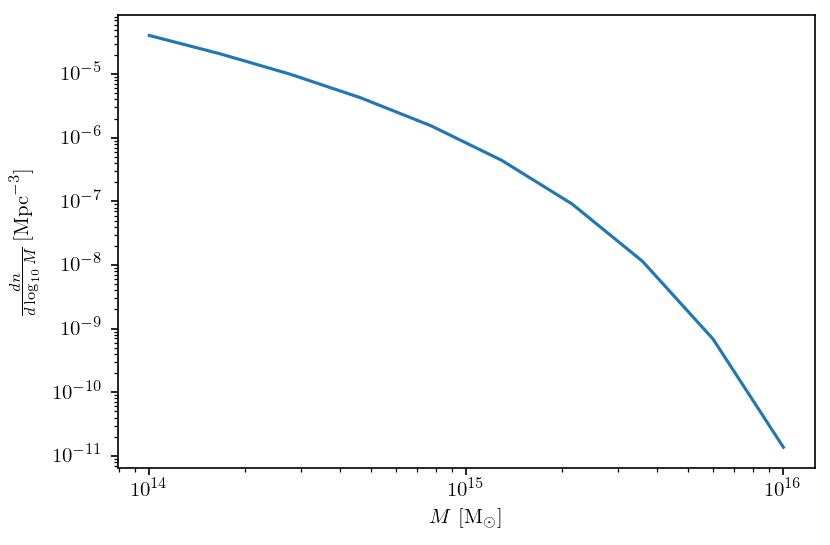

In [10]:
plt.figure()
plt.ylabel(r'$\frac{dn}{d\log_{10}M}\,[{\rm Mpc}^{-3}]$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(masses, hmc, c=color_map(0))

## Try np.trapz

In [11]:
# compute dN/dlog10Mdz
z_i = 0.1
z_f = 0.2

log10m_i = 14.0
log10m_f = 14.5

n_steps_masses = 100
n_steps_z = 100

z_steps = np.linspace(z_i, z_f, num = n_steps_z)
log10masses_steps = np.linspace(log10m_i, log10m_f, num = n_steps_masses)
dN_dlog10Mdz = n_counts_func.halo_mass_function(theta_fiducial, 10**log10masses_steps, z_i)
#dN_dlog10Mdz

In [12]:
# compute compute dN/dlog10Mdz with a function from .py file to compare
log10masses = np.linspace(log10m_i, log10m_f, num = 10)
dN_integral = n_counts_func.n_counts_m_integral(log10masses, z_i, theta_fiducial)

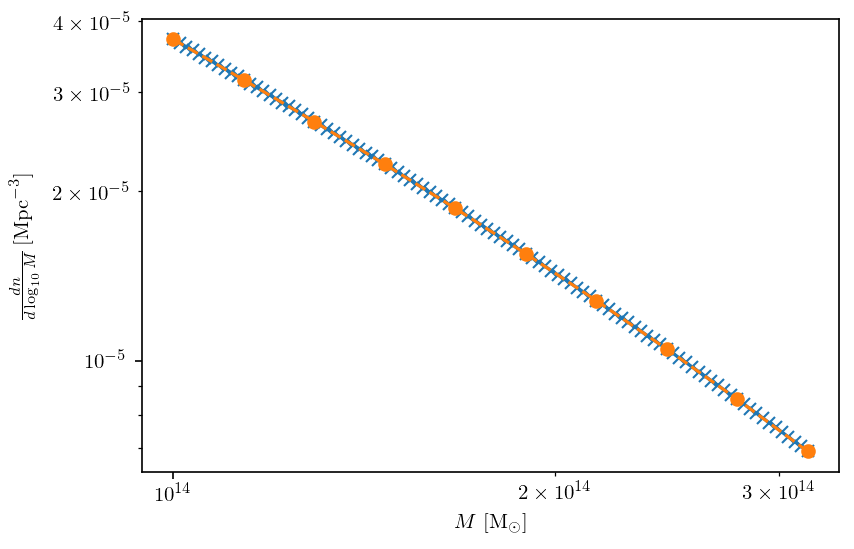

In [13]:
plt.figure()
plt.ylabel(r'$\frac{dn}{d\log_{10}M}\,[{\rm Mpc}^{-3}]$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
plt.plot(10**log10masses_steps, dN_dlog10Mdz, c=color_map(0), marker='x')
plt.plot(10**log10masses, dN_integral, c=color_map(1), marker='o', linestyle = '--')

## Compare results and time it takes to compute N counts for a single mass bin at some redshift $z_{i}$ 

### (1) using integrate.quad

In [14]:
tic = time.process_time()
N_counts_temp_integral = n_counts_func.n_counts_m_integral_only(z_i, log10m_i, log10m_f, theta_fiducial)
toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_temp_integral)

2.1807643479999994 s
9.33114057941002e-06


### (2) using np.trapz w/ n = 100 steps

In [15]:
tic = time.process_time()
N_counts_temp = np.trapz(dN_dlog10Mdz, log10masses_steps)
toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_temp)

0.0002193940000001504 s
9.331338998123629e-06


## Compare results and time it takes to compute N counts for a single mass bin and a redshift bin

### (1) using integrate.quad

In [16]:
tic = time.process_time()
N_counts_temp_integral = n_counts_func.n_counts(z_i, z_f, log10m_i, log10m_f, theta_fiducial)
toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_temp_integral)

47.72872022 s
17848.461278302013


### (2) using np.trapz and a loop

In [17]:
tic = time.process_time()

N_counts_dz = np.zeros(n_steps_z)
cosmo_ccl = n_counts_func.cosmo(theta_fiducial)
H0 = 100*theta_fiducial[3]
c = ccl.physical_constants.CLIGHT*1e-3 # in km/s

scale_fact_a = 1/(1+z_steps)
H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
factor = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)

for i in range(len(z_steps)):

    dN_dlog10Mdz = n_counts_func.halo_mass_function(theta_fiducial, 10**log10masses_steps, z_steps[i])
    N_counts_dz[i] = factor[i]*np.trapz(dN_dlog10Mdz, log10masses_steps)

N_counts_trapz = np.trapz(N_counts_dz, z_steps)    

toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_trapz)

10.412020099000003 s
17848.906362935126


## N counts for theta_fiducial computed with integrate.quad

In [18]:
N_counts_fiducial = np.array([[1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04, 5.88511940e+04],
                                [2.53148842e+03, 6.50855639e+03, 6.79903632e+03, 4.77688556e+03, 2.60820123e+03],
                                [1.41327071e+02, 2.40973371e+02, 1.54407289e+02, 6.19683804e+01, 1.80223466e+01],
                                [1.15793270e+00, 8.97133179e-01, 2.22000351e-01, 2.95440371e-02, 2.45071739e-03]])

## All the different values and times, values/times[z_bin][n_steps_z][n_steps_mass][mass_bin]

In [19]:
n_steps_z_arr = np.array([100, 200])
n_steps_masses_arr = ([100, 200, 500, 1000])

In [21]:
values_all = np.array([[[[1.78489064e+04, 2.53159409e+03, 1.41340307e+02, 1.15828437e+00],
        [1.78486399e+04, 2.53152195e+03, 1.41330161e+02, 1.15801451e+00],
        [1.78485662e+04, 2.53150200e+03, 1.41327355e+02, 1.15793987e+00],
        [1.78485558e+04, 2.53149917e+03, 1.41326957e+02, 1.15792928e+00]],

       [[1.78488711e+04, 2.53159270e+03, 1.41340546e+02, 1.15828995e+00],
        [1.78486046e+04, 2.53152056e+03, 1.41330400e+02, 1.15802010e+00],
        [1.78485309e+04, 2.53150061e+03, 1.41327594e+02, 1.15794546e+00],
        [1.78485205e+04, 2.53149778e+03, 1.41327196e+02, 1.15793486e+00]]],


       [[[5.76984723e+04, 6.50888634e+03, 2.41004092e+02,
          8.97521927e-01],
         [5.76974258e+04, 6.50864642e+03, 2.40980751e+02,
          8.97229656e-01],
         [5.76971365e+04, 6.50858007e+03, 2.40974295e+02,
          8.97148814e-01],
         [5.76970955e+04, 6.50857065e+03, 2.40973379e+02,
          8.97137339e-01]],

        [[5.76985070e+04, 6.50889316e+03, 2.41004414e+02,
          8.97521980e-01],
         [5.76974605e+04, 6.50865324e+03, 2.40981073e+02,
          8.97229709e-01],
         [5.76971713e+04, 6.50858689e+03, 2.40974617e+02,
          8.97148866e-01],
         [5.76971302e+04, 6.50857747e+03, 2.40973700e+02,
          8.97137392e-01]]],


       [[[7.91983098e+04, 6.79948852e+03, 1.54434445e+02,
          2.22137089e-01],
         [7.91965294e+04, 6.79916000e+03, 1.54414089e+02,
          2.22035128e-01],
         [7.91960372e+04, 6.79906913e+03, 1.54408458e+02,
          2.22006925e-01],
         [7.91959673e+04, 6.79905624e+03, 1.54407659e+02,
          2.22002922e-01]],

        [[7.91983513e+04, 6.79949223e+03, 1.54434430e+02,
          2.22136222e-01],
         [7.91965709e+04, 6.79916371e+03, 1.54414073e+02,
          2.22034262e-01],
         [7.91960787e+04, 6.79907284e+03, 1.54408442e+02,
          2.22006058e-01],
         [7.91960089e+04, 6.79905995e+03, 1.54407643e+02,
          2.22002055e-01]]],


       [[[7.60308697e+04, 4.77730186e+03, 6.19832601e+01,
          2.95696148e-02],
         [7.60287305e+04, 4.77699906e+03, 6.19721727e+01,
          2.95505952e-02],
         [7.60281390e+04, 4.77691531e+03, 6.19691059e+01,
          2.95453340e-02],
         [7.60280551e+04, 4.77690342e+03, 6.19686706e+01,
          2.95445872e-02]],

        [[7.60308920e+04, 4.77730189e+03, 6.19831740e+01,
          2.95693937e-02],
         [7.60287528e+04, 4.77699908e+03, 6.19720866e+01,
          2.95503742e-02],
         [7.60281613e+04, 4.77691533e+03, 6.19690198e+01,
          2.95451130e-02],
         [7.60280774e+04, 4.77690345e+03, 6.19685845e+01,
          2.95443662e-02]]],


       [[[5.88540746e+04, 2.60849702e+03, 1.80281879e+01,
          2.45365876e-03],
         [5.88519958e+04, 2.60828121e+03, 1.80238449e+01,
          2.45147271e-03],
         [5.88514211e+04, 2.60822152e+03, 1.80226437e+01,
          2.45086797e-03],
         [5.88513395e+04, 2.60821304e+03, 1.80224732e+01,
          2.45078214e-03]],

        [[5.88540780e+04, 2.60849571e+03, 1.80281410e+01,
          2.45363173e-03],
         [5.88519992e+04, 2.60827990e+03, 1.80237981e+01,
          2.45144570e-03],
         [5.88514244e+04, 2.60822021e+03, 1.80225968e+01,
          2.45084096e-03],
         [5.88513428e+04, 2.60821174e+03, 1.80224263e+01,
          2.45075513e-03]]]])

In [22]:
times_all = np.array([[[[12.26469124, 12.17994351, 12.19778423, 12.20276439],
        [12.2010028 , 12.19110354, 12.18053662, 12.18394996],
        [12.20314828, 12.17835917, 12.23041168, 12.20841543],
        [12.22332429, 12.22377625, 12.20731452, 12.30080098]],

       [[24.28890007, 24.2664371 , 24.32933213, 24.2560207 ],
        [24.26584089, 24.21834908, 24.21479832, 24.24852977],
        [24.22230234, 24.2366613 , 24.27759315, 24.27768597],
        [24.33314432, 24.33293843, 24.32311449, 24.30140122]]],


       [[[13.43187315, 13.42064314, 13.4153219 , 13.42658235],
         [13.41405974, 13.41246842, 13.40161436, 13.40565994],
         [13.42470319, 13.40694849, 13.40876838, 13.42849338],
         [13.42810331, 13.44015299, 13.4301618 , 13.42852103]],

        [[26.68648996, 26.69472009, 26.66936787, 26.69421074],
         [26.69374527, 26.71736238, 26.70503713, 26.70565417],
         [26.72323888, 26.72665427, 26.73916484, 26.81559678],
         [26.73174442, 26.73931688, 26.85370005, 26.77613011]]],


       [[[13.42014653, 13.40606511, 13.41692681, 13.4162733 ],
         [13.42859403, 13.42238077, 13.41394104, 13.43206763],
         [13.42993348, 13.43545359, 13.43807435, 13.42803112],
         [13.44665825, 13.4376927 , 13.44586431, 13.44157962]],

        [[26.69041773, 26.69018868, 26.70830405, 26.71956426],
         [26.71723191, 26.72244365, 26.69684108, 26.71350318],
         [26.70618968, 26.73078173, 26.74091163, 26.73313655],
         [26.75699824, 26.74095633, 26.72636625, 26.7247032 ]]],


       [[[13.38915753, 13.40738648, 13.39731522, 13.3945273 ],
         [13.39580932, 13.40830874, 13.37698329, 13.37584169],
         [13.38914365, 13.41061661, 13.41204137, 13.40508446],
         [13.42153817, 13.40118896, 13.42940687, 13.42641809]],

        [[26.64665957, 26.67769919, 26.65469437, 26.65221753],
         [26.64544243, 26.66799909, 26.65156914, 26.67442073],
         [26.66177254, 26.69633127, 26.67438964, 26.68775127],
         [26.73728808, 26.72988745, 26.71636064, 26.69047412]]],


       [[[13.38671507, 13.38692617, 13.39258108, 13.40409908],
         [13.39258079, 13.3974354 , 13.38756927, 13.39194879],
         [13.40324687, 13.39258338, 13.40186727, 13.3911772 ],
         [13.42145149, 13.43811651, 13.42388363, 13.4235526 ]],

        [[26.66375965, 26.6727451 , 26.65922851, 26.65683184],
         [26.66655542, 26.62975255, 26.65466908, 26.66911673],
         [26.67690555, 26.69131101, 26.67182411, 26.66053044],
         [26.7333061 , 26.74575449, 26.72050268, 26.78395274]]]])

In [ ]:
diffs = values[] - N_counts

plt.figure()
plt.ylabel(r'$\Delta N$')
plt.xlabel(r'$\log_{10}M$ [M$_{\odot}$]')
#plt.xscale('log')
#plt.yscale('log')

for i in range(len(n_steps_z_arr)):
    for j in range(len(n_steps_masses_arr)):
        plt.plot(log10mass_bins[:-1], diffs[i][j][:]/N_counts)

In [34]:
np.set_printoptions(suppress=True)
for i in range(N_counts_fiducial.shape[1]):
    print("z_bin # " + str(i) + ": "+ str(N_counts_fiducial[:, i]))

z_bin # 0: [17848.4613     2531.48842     141.327071      1.1579327]
z_bin # 1: [57696.9893      6508.55639      240.973371       0.89713318]
z_bin # 2: [79195.8165      6799.03632      154.407289       0.22200035]
z_bin # 3: [76027.8893      4776.88556       61.9683804      0.02954404]
z_bin # 4: [58851.194       2608.20123       18.0223466      0.00245072]


In [43]:
for i in range(values_all.shape[0]):
    print("z_bin # " + str(i) + ": "+ str(values_all[i, 0, 3, :]))

z_bin # 0: [17848.5558      2531.49917      141.326957       1.15792928]
z_bin # 1: [57697.0955      6508.57065      240.973379       0.89713734]
z_bin # 2: [79195.9673      6799.05624      154.407659       0.22200292]
z_bin # 3: [76028.0551      4776.90342       61.9686706      0.02954459]
z_bin # 4: [58851.3395      2608.21304       18.0224732      0.00245078]


In [48]:
for j in range(values_all.shape[2]):
    print("n_steps_masses: " + str(n_steps_masses_arr[j]))
    for i in range(values_all.shape[0]):
        print("z_bin # " + str(i) + ": "+ str(values_all[i, 0, j, :]))
    
    print()
    print("Difference w/ integrate.quad")
    for i in range(values_all.shape[0]):    
        
        print("z_bin # " + str(i) + ": "+ str(values_all[i, 0, j, :] - N_counts_fiducial[:, i]))
    print()

n_steps_masses: 100
z_bin # 0: [17848.9064      2531.59409      141.340307       1.15828437]
z_bin # 1: [57698.4723      6508.88634      241.004092       0.89752193]
z_bin # 2: [79198.3098      6799.48852      154.434445       0.22213709]
z_bin # 3: [76030.8697      4777.30186       61.9832601      0.02956961]
z_bin # 4: [58854.0746      2608.49702       18.0281879      0.00245366]

Difference w/ integrate.quad
z_bin # 0: [0.4451     0.10567    0.013236   0.00035167]
z_bin # 1: [1.483      0.32995    0.030721   0.00038875]
z_bin # 2: [2.4933     0.4522     0.027156   0.00013674]
z_bin # 3: [2.9804     0.4163     0.0148797  0.00002558]
z_bin # 4: [2.8806     0.29579    0.0058413  0.00000294]

n_steps_masses: 200
z_bin # 0: [17848.6399      2531.52195      141.330161       1.15801451]
z_bin # 1: [57697.4258      6508.64642      240.980751       0.89722966]
z_bin # 2: [79196.5294      6799.16         154.414089       0.22203513]
z_bin # 3: [76028.7305     4776.99906      61.9721727     0.

In [49]:
times_all[:, 0, 3, :]

array([[12.22332429, 12.22377625, 12.20731452, 12.30080098],
       [13.42810331, 13.44015299, 13.4301618 , 13.42852103],
       [13.44665825, 13.4376927 , 13.44586431, 13.44157962],
       [13.42153817, 13.40118896, 13.42940687, 13.42641809],
       [13.42145149, 13.43811651, 13.42388363, 13.4235526 ]])

In [50]:
times_all[:, 0, 2, :]

array([[12.20314828, 12.17835917, 12.23041168, 12.20841543],
       [13.42470319, 13.40694849, 13.40876838, 13.42849338],
       [13.42993348, 13.43545359, 13.43807435, 13.42803112],
       [13.38914365, 13.41061661, 13.41204137, 13.40508446],
       [13.40324687, 13.39258338, 13.40186727, 13.3911772 ]])

In [51]:
times_all[:, 0, 3, :] - times_all[:, 0, 2, :]

array([[ 0.02017601,  0.04541708, -0.02309716,  0.09238555],
       [ 0.00340012,  0.0332045 ,  0.02139342,  0.00002765],
       [ 0.01672477,  0.00223911,  0.00778996,  0.0135485 ],
       [ 0.03239452, -0.00942765,  0.0173655 ,  0.02133363],
       [ 0.01820462,  0.04553313,  0.02201636,  0.0323754 ]])

In [22]:
# compute dN/dlog10Mdz
z_i = 0.1
z_f = 0.2

log10m_i = 14.5
log10m_f = 15

n_steps_masses = 500
n_steps_z = 100

z_steps = np.linspace(z_i, z_f, num = n_steps_z)
log10masses_steps = np.linspace(log10m_i, log10m_f, num = n_steps_masses)


In [23]:
tic = time.process_time()

N_counts_dz = np.zeros(n_steps_z)
cosmo_ccl = n_counts_func.cosmo(theta_fiducial)
H0 = 100*theta_fiducial[3]
c = ccl.physical_constants.CLIGHT*1e-3 # in km/s

scale_fact_a = 1/(1+z_steps)
H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
factor = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)
    
for i in range(len(z_steps)):

    dN_dlog10Mdz = n_counts_func.halo_mass_function(theta_fiducial, 10**log10masses_steps, z_steps[i])
    N_counts_dz[i] = factor[i]*np.trapz(dN_dlog10Mdz, log10masses_steps)

N_counts_trapz = np.trapz(N_counts_dz, z_steps)    

toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_trapz)

14.048996404999997 s
2531.5019980747916


## Quick Check with Arrays

In [29]:
log10mass_bins = np.linspace(14, 16, 5)
log10mass_bins

array([14. , 14.5, 15. , 15.5, 16. ])

In [30]:
n_steps_z_arr = np.array([100, 200])
n_steps_masses_arr = ([100, 200, 500, 1000])
abs_diff = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))
int_diff = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))
times  = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))

values = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))

In [34]:
for i in range(len(n_steps_z_arr)):
    z_steps = np.linspace(z_i, z_f, num = n_steps_z_arr[i])
    
    for j in range(len(n_steps_masses_arr)):
        # log10masses_steps = np.linspace(log10m_i, log10m_f, num = n_steps_masses_arr[j])
        
        
        for n in range(len(log10mass_bins)-1):
            log10masses_steps = np.linspace(log10mass_bins[n], log10mass_bins[n+1], num = n_steps_masses_arr[j])
            
            tic = time.process_time()
            
            N_counts_dz = np.zeros(n_steps_z_arr[i])
            cosmo_ccl = n_counts_func.cosmo(theta_fiducial)
            H0 = 100*theta_fiducial[3]
            c = ccl.physical_constants.CLIGHT*1e-3 # in km/s
        
            scale_fact_a = 1/(1+z_steps)
            H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
            factor = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)
    
            for k in range(len(z_steps)):

                dN_dlog10Mdz = n_counts_func.halo_mass_function(theta_fiducial, 10**log10masses_steps, z_steps[k])
                N_counts_dz[k] = factor[k]*np.trapz(dN_dlog10Mdz, log10masses_steps)

            N_counts_trapz = np.trapz(N_counts_dz, z_steps)    
            toc = time.process_time()
        
            values[i][j][n] = N_counts_trapz
            times[i][j][n] = toc-tic
        
            
            # print the iteration
            print(i, j, n)
            print(times[i][j][n])
        

0 0 0
12.264691240000005
0 0 1
12.179943512999984
0 0 2
12.197784229999996
0 0 3
12.202764389999999
0 1 0
12.201002801999977
0 1 1
12.191103537999993
0 1 2
12.180536617000001
0 1 3
12.183949963999993
0 2 0
12.20314828299999
0 2 1
12.178359172
0 2 2
12.230411683
0 2 3
12.20841543200001
0 3 0
12.223324294999998
0 3 1
12.223776251999993
0 3 2
12.207314523999969
0 3 3
12.300800981000009
1 0 0
24.288900069999954
1 0 1
24.266437096000004
1 0 2
24.329332131
1 0 3
24.256020696000007
1 1 0
24.265840889000003
1 1 1
24.218349085
1 1 2
24.214798324000014
1 1 3
24.248529765
1 2 0
24.22230234400007
1 2 1
24.236661303000005
1 2 2
24.277593152999998
1 2 3
24.277685970999983
1 3 0
24.333144319999974
1 3 1
24.33293843199999
1 3 2
24.323114487999987
1 3 3
24.301401220999992


In [35]:
times

array([[[12.26469124, 12.17994351, 12.19778423, 12.20276439],
        [12.2010028 , 12.19110354, 12.18053662, 12.18394996],
        [12.20314828, 12.17835917, 12.23041168, 12.20841543],
        [12.22332429, 12.22377625, 12.20731452, 12.30080098]],

       [[24.28890007, 24.2664371 , 24.32933213, 24.2560207 ],
        [24.26584089, 24.21834908, 24.21479832, 24.24852977],
        [24.22230234, 24.2366613 , 24.27759315, 24.27768597],
        [24.33314432, 24.33293843, 24.32311449, 24.30140122]]])

In [36]:
values

array([[[1.78489064e+04, 2.53159409e+03, 1.41340307e+02, 1.15828437e+00],
        [1.78486399e+04, 2.53152195e+03, 1.41330161e+02, 1.15801451e+00],
        [1.78485662e+04, 2.53150200e+03, 1.41327355e+02, 1.15793987e+00],
        [1.78485558e+04, 2.53149917e+03, 1.41326957e+02, 1.15792928e+00]],

       [[1.78488711e+04, 2.53159270e+03, 1.41340546e+02, 1.15828995e+00],
        [1.78486046e+04, 2.53152056e+03, 1.41330400e+02, 1.15802010e+00],
        [1.78485309e+04, 2.53150061e+03, 1.41327594e+02, 1.15794546e+00],
        [1.78485205e+04, 2.53149778e+03, 1.41327196e+02, 1.15793486e+00]]])

## compute baseline using integrate.quad

In [39]:
N_counts = np.zeros(4)

In [41]:
tic = time.process_time()
for i in range(len(log10mass_bins) - 1):
    N_counts_temp = n_counts_func.n_counts(z_i, z_f, log10mass_bins[i], log10mass_bins[i+1], theta_fiducial)
    N_counts[i] = N_counts_temp
    print(i)
toc = time.process_time()
print(str((toc-tic)) + ' s')

0
1
2
3
222.08767015799992 s


In [42]:
N_counts

array([1.78484613e+04, 2.53148842e+03, 1.41327071e+02, 1.15793270e+00])

## compare

n_steps_z_arr = np.array([100, 200])
n_steps_masses_arr = ([100, 200, 500, 1000])
abs_diff = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))
int_diff = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))
times  = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))

values = np.zeros((len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))

In [46]:
diffs = values - N_counts
diffs

array([[[ 4.45084633e-01,  1.05662576e-01,  1.32356732e-02,
          3.51669419e-04],
        [ 1.78596556e-01,  3.35259413e-02,  3.09004518e-03,
          8.18165417e-05],
        [ 1.04941523e-01,  1.35744999e-02,  2.83802666e-04,
          7.17638390e-06],
        [ 9.44857260e-02,  1.07427917e-02, -1.14480700e-04,
         -3.41757678e-06]],

       [[ 4.09802317e-01,  1.04273945e-01,  1.34746505e-02,
          3.57252673e-04],
        [ 1.43315126e-01,  3.21374713e-02,  3.32902222e-03,
          8.73988126e-05],
        [ 6.96603372e-02,  1.21860743e-02,  5.22779620e-04,
          1.27583828e-05],
        [ 5.92045751e-02,  9.35437241e-03,  1.24496241e-04,
          2.16438355e-06]]])

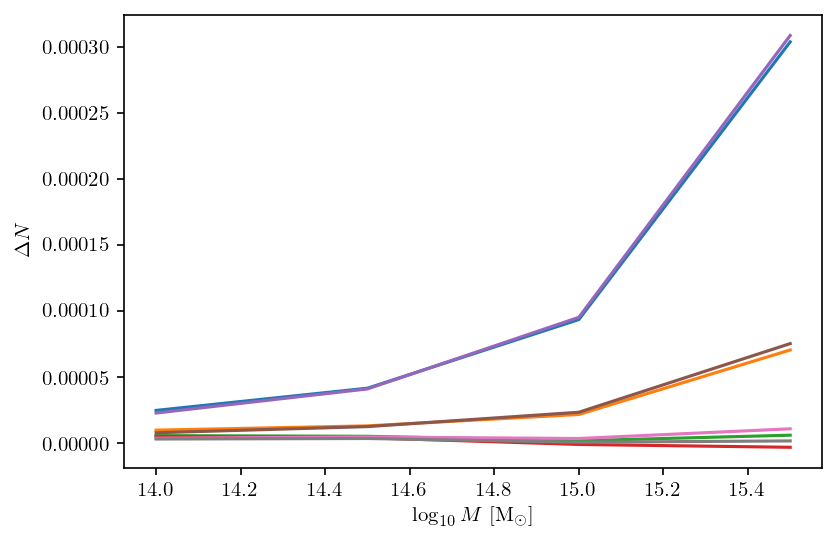

In [55]:
plt.figure()


plt.ylabel(r'$\Delta N$')
plt.xlabel(r'$\log_{10}M$ [M$_{\odot}$]')
#plt.xscale('log')
#plt.yscale('log')

for i in range(len(n_steps_z_arr)):
    for j in range(len(n_steps_masses_arr)):
        plt.plot(log10mass_bins[:-1], diffs[i][j][:]/N_counts)


In [27]:
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)

In [32]:
times_all = np.zeros((len(z_min), len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))
values_all = np.zeros((len(z_min), len(n_steps_z_arr), len(n_steps_masses_arr), len(log10mass_bins)-1))

In [34]:
for i in range(1, len(z_min)):
    print(i)

1
2
3
4


In [37]:
for m in range(1, len(z_min)):

    for i in range(len(n_steps_z_arr)):
        z_steps = np.linspace(z_min[m], z_max[m], num = n_steps_z_arr[i])

        for j in range(len(n_steps_masses_arr)):
            # log10masses_steps = np.linspace(log10m_i, log10m_f, num = n_steps_masses_arr[j])


            for n in range(len(log10mass_bins)-1):
                log10masses_steps = np.linspace(log10mass_bins[n], log10mass_bins[n+1], num = n_steps_masses_arr[j])

                tic = time.process_time()

                N_counts_dz = np.zeros(n_steps_z_arr[i])
                cosmo_ccl = n_counts_func.cosmo(theta_fiducial)
                H0 = 100*theta_fiducial[3]
                c = ccl.physical_constants.CLIGHT*1e-3 # in km/s

                scale_fact_a = 1/(1+z_steps)
                H_z = H0*ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)
                factor = 4*np.pi*(c/H_z)*(ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)**2)

                for k in range(len(z_steps)):

                    dN_dlog10Mdz = n_counts_func.halo_mass_function(theta_fiducial, 10**log10masses_steps, z_steps[k])
                    N_counts_dz[k] = factor[k]*np.trapz(dN_dlog10Mdz, log10masses_steps)

                N_counts_trapz = np.trapz(N_counts_dz, z_steps)    
                toc = time.process_time()

                values_all[m][i][j][n] = N_counts_trapz
                times_all[m][i][j][n] = toc-tic


                # print the iteration
                print('z_min: ' + str(z_min[m]))
                print(m, i, j, n)
                print(times_all[m][i][j][n])


z_min: 0.30000000000000004
1 0 0 0
13.431873147999994
z_min: 0.30000000000000004
1 0 0 1
13.420643141999989
z_min: 0.30000000000000004
1 0 0 2
13.415321898000002
z_min: 0.30000000000000004
1 0 0 3
13.426582349
z_min: 0.30000000000000004
1 0 1 0
13.414059737999992
z_min: 0.30000000000000004
1 0 1 1
13.412468422999979
z_min: 0.30000000000000004
1 0 1 2
13.401614361000014
z_min: 0.30000000000000004
1 0 1 3
13.405659944000007
z_min: 0.30000000000000004
1 0 2 0
13.424703193999989
z_min: 0.30000000000000004
1 0 2 1
13.406948494000005
z_min: 0.30000000000000004
1 0 2 2
13.408768382999995
z_min: 0.30000000000000004
1 0 2 3
13.428493376000006
z_min: 0.30000000000000004
1 0 3 0
13.428103310999973
z_min: 0.30000000000000004
1 0 3 1
13.440152994000016
z_min: 0.30000000000000004
1 0 3 2
13.430161801999986
z_min: 0.30000000000000004
1 0 3 3
13.428521031999992
z_min: 0.30000000000000004
1 1 0 0
26.686489956999992
z_min: 0.30000000000000004
1 1 0 1
26.694720086000018
z_min: 0.30000000000000004
1 1 0 2

In [38]:
values_all

array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
          0.00000000e+00]]],


       [[[5.76984723e+04, 6.50888634e+03, 2.41004092e+02,
          8.97521927e-01],
         [5.76974258e+04, 6.50864642e+03, 2.40980751e+02,
          8.97229656e-01],
         [5.76971365e+04, 6.50858007e+03, 2.40974295e+02,
          8.97148814e-01],
         [5.76970955e+04, 6.50857065e+03, 2.40973379e+02,
 

In [39]:
times_all

array([[[[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ]],

        [[ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ]]],


       [[[13.43187315, 13.42064314, 13.4153219 , 13.42658235],
         [13.41405974, 13.41246842, 13.40161436, 13.40565994],
         [13.42470319, 13.40694849, 13.40876838, 13.42849338],
         [13.42810331, 13.44015299, 13.4301618 , 13.42852103]],

        [[26.68648996, 26.69472009, 26.66936787, 26.69421074],
         [26.69374527, 26.71736238, 26.70503713, 26.70565417],
         [26.72323888, 26.72665427, 26.73916484, 26.81559678],
         [26.73174442, 26.73931688, 26.85370005

In [68]:
ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)

array([424.57962607, 470.5105453 , 516.18847531, 561.61273627,
       606.78250109, 651.69707751, 696.35600653, 740.75871639,
       784.90475688, 828.79380827])

In [19]:
tic = time.process_time()
N_counts_temp_integral = n_counts_func.n_counts_m_integral_only(z_i, 14, 14.5, theta_fiducial)
toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_temp_integral)

2.311014062 s
9.33114057941002e-06


In [45]:
tic = time.process_time()
N_counts_temp_integral = n_counts_func.n_counts(0.1, 0.2, 14, 14.5, theta_fiducial)
toc = time.process_time()
print(str((toc-tic)) + ' s')
print(N_counts_temp_integral)

45.629609736999996 s
17848.461278302013


In [13]:
dN_dlog10Mdz

array([3.71668293e-05, 3.14923645e-05, 2.65682025e-05, 2.23096201e-05,
       1.86375832e-05, 1.54838204e-05, 1.27846692e-05, 1.04877137e-05,
       8.54189785e-06, 6.90301960e-06])

In [39]:
masses

array([1.00000000e+14, 1.13646367e+14, 1.29154967e+14, 1.46779927e+14,
       1.66810054e+14, 1.89573565e+14, 2.15443469e+14, 2.44843675e+14,
       2.78255940e+14, 3.16227766e+14])

In [13]:
log10masses = np.linspace(14, 14.5, num = 10)
log10masses

array([14.        , 14.05555556, 14.11111111, 14.16666667, 14.22222222,
       14.27777778, 14.33333333, 14.38888889, 14.44444444, 14.5       ])

In [14]:
dN_integral = n_counts_func.n_counts_m_integral(log10masses, z_i, theta_fiducial)
dN_integral 

array([3.71668293e-05, 3.14923645e-05, 2.65682025e-05, 2.23096201e-05,
       1.86375832e-05, 1.54838204e-05, 1.27846692e-05, 1.04877137e-05,
       8.54189785e-06, 6.90301960e-06])

In [26]:
tic = time.process_time()
N_counts_temp = n_counts_func.n_counts(z_min[0], z_max[0], log10masses[0], log10masses[1], theta_fiducial)
print(N_counts_temp)
toc = time.process_time()
print(str((toc-tic)) + ' s')

array([1.00000000e+14, 1.66810054e+14, 2.78255940e+14, 4.64158883e+14,
       7.74263683e+14, 1.29154967e+15, 2.15443469e+15, 3.59381366e+15,
       5.99484250e+15, 1.00000000e+16])

In [27]:
hmc

array([4.35704540e-05, 2.30531271e-05, 1.11127857e-05, 4.67867934e-06,
       1.61791214e-06, 4.19624966e-07, 7.12966974e-08, 6.46773442e-09,
       2.28982370e-10, 1.94521904e-12])

In [31]:
x = np.linspace(0, 4)
y = x**2

In [32]:
np.trapz(y, x)

21.337775926697212

In [25]:
x2 = lambda x: x**2

In [27]:
scipy.integrate.quad(x2, 0, 4)

(21.333333333333336, 2.368475785867001e-13)

In [28]:
4**3 / 3.

21.333333333333332

# Compute N number counts integral for 1 redshift bin

In [14]:
log10masses = np.linspace(14, 16, num = 5)
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
N_counts = np.zeros((len(log10masses)-1, len(z_min)))
N_counts

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

## (1) check how long it takes to do it with scipy.integrate.quad 

### for a single value

In [28]:
tic = time.process_time()
N_counts_temp = n_counts_func.n_counts(z_min[0], z_max[0], log10masses[0], log10masses[1], theta_fiducial)
print(N_counts_temp)
toc = time.process_time()
print(str((toc-tic)) + ' s')

17848.461278302013
45.42138853100005 s


### for a set of n = 20 values 

In [22]:
tic = time.process_time()
for i in range(len(log10masses) - 1):
    for j in range(len(z_min)):
        N_counts_temp = n_counts_func.n_counts(z_min[j], z_max[j], log10masses[i], log10masses[i+1], theta_fiducial)
        N_counts[i][j] = N_counts_temp
        print(i, j)
toc = time.process_time()
print(str((toc-tic)) + ' s')

0 0
0 1
0 2
0 3
0 4
1 0
1 1
1 2
1 3
1 4
2 0
2 1
2 2
2 3
2 4
3 0
3 1
3 2
3 3
3 4
1185.5688114630002 s


In [23]:
(toc-tic)/20

59.27844057315001

In [24]:
N_counts

array([[1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04,
        5.88511940e+04],
       [2.53148842e+03, 6.50855639e+03, 6.79903632e+03, 4.77688556e+03,
        2.60820123e+03],
       [1.41327071e+02, 2.40973371e+02, 1.54407289e+02, 6.19683804e+01,
        1.80223466e+01],
       [1.15793270e+00, 8.97133179e-01, 2.22000351e-01, 2.95440371e-02,
        2.45071739e-03]])

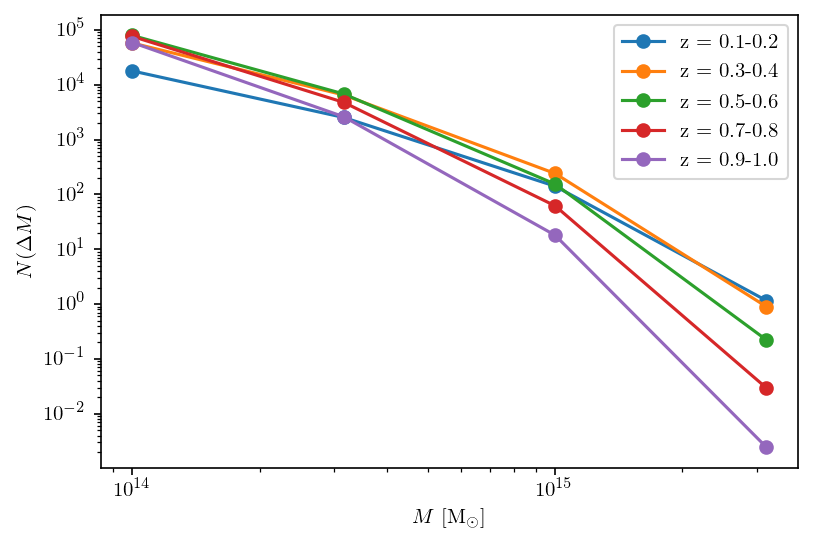

In [25]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
for j in range(len(z_min)):
    plt.plot(10**log10masses[:-1], N_counts[:, j], c=color_map(j), marker = 'o', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

In [2]:

tic = time.process_time()
print("Hi!")
toc = time.process_time()
print("\n ----- Computation time = " + str(1000*(toc - tic)) + "ms")

Hi!

 ----- Computation time = 0.2743970000000373ms


# Draw a distribution of N number counts, given fiducial distribution $N_{i}$

In [22]:
N_counts_random = n_counts_func.random_realization_n_counts(N_counts)

In [23]:
N_counts

array([[1.78484613e+04, 5.76969893e+04, 7.91958165e+04, 7.60278893e+04,
        5.88511940e+04],
       [2.53148842e+03, 6.50855639e+03, 6.79903632e+03, 4.77688556e+03,
        2.60820123e+03],
       [1.41327071e+02, 2.40973371e+02, 1.54407289e+02, 6.19683804e+01,
        1.80223466e+01],
       [1.15793270e+00, 8.97133179e-01, 2.22000351e-01, 2.95440371e-02,
        2.45071739e-03]])

In [24]:
N_counts_random

array([[17873, 58171, 78992, 75786, 59041],
       [ 2504,  6389,  6732,  4771,  2595],
       [  122,   247,   154,    58,    18],
       [    3,     0,     1,     0,     0]])

In [25]:
np.load('N_counts_random_data.npy')

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

In [29]:
N_random = np.random.poisson(N_counts)
N_random

array([[17720, 57628, 78955, 75947, 58462],
       [ 2499,  6606,  6684,  4733,  2579],
       [  140,   228,   173,    55,    15],
       [    1,     0,     0,     1,     0]])

In [31]:
np.save("N_counts_random_data.npy", N_random)

# Detailed Plot

In [15]:
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses_detailed = np.linspace(14, 16, num = 10)

In [16]:
N_counts_detailed = np.array([[1.15800327e+04, 3.85834339e+04, 5.48042661e+04, 5.45712084e+04,
        4.38588032e+04],
       [5.47583409e+03, 1.68390172e+04, 2.16995672e+04, 1.92924755e+04,
        1.36313954e+04],
       [2.31865812e+03, 6.41774238e+03, 7.27956167e+03, 5.58042923e+03,
        3.33262858e+03],
       [8.41486306e+02, 2.02583289e+03, 1.94110400e+03, 1.22370005e+03,
        5.85668406e+02],
       [2.45808466e+02, 4.91071578e+02, 3.75712289e+02, 1.82594335e+02,
        6.51411299e+01],
       [5.27963288e+01, 8.20251564e+01, 4.63703653e+01, 1.58960505e+01,
        3.82588664e+00],
       [7.31509284e+00, 8.07561038e+00, 3.02840186e+00, 6.46889355e-01,
        9.13048543e-02],
       [5.40535285e-01, 3.73460918e-01, 7.97280515e-02, 8.88482564e-03,
        6.00325839e-04],
       [1.60960875e-02, 5.79328709e-03, 5.62797655e-04, 2.51510800e-05,
        6.01111023e-07]])
N_counts_random_mean_detailed = np.array([[1.158201e+04, 3.855427e+04, 5.480429e+04, 5.458782e+04,
        4.385724e+04],
       [5.474580e+03, 1.684756e+04, 2.171374e+04, 1.928909e+04,
        1.365613e+04],
       [2.315530e+03, 6.413670e+03, 7.278720e+03, 5.572230e+03,
        3.323130e+03],
       [8.442400e+02, 2.021900e+03, 1.938690e+03, 1.217850e+03,
        5.859000e+02],
       [2.471400e+02, 4.894900e+02, 3.781900e+02, 1.829600e+02,
        6.439000e+01],
       [5.287000e+01, 8.281000e+01, 4.662000e+01, 1.607000e+01,
        3.970000e+00],
       [7.250000e+00, 8.450000e+00, 3.070000e+00, 7.100000e-01,
        1.100000e-01],
       [4.500000e-01, 3.200000e-01, 5.000000e-02, 3.000000e-02,
        0.000000e+00],
       [1.000000e-02, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00]])
N_counts_random_var_detailed = np.array([[9.10840990e+03, 3.97675371e+04, 4.59156659e+04, 5.67031476e+04,
        3.16554424e+04],
       [5.51896360e+03, 1.20694464e+04, 2.26114324e+04, 1.50395419e+04,
        1.07326331e+04],
       [2.11180910e+03, 9.00812110e+03, 8.07908160e+03, 4.88149710e+03,
        3.49105310e+03],
       [6.99622400e+02, 2.39467000e+03, 1.68503390e+03, 1.20452750e+03,
        5.40850000e+02],
       [2.87620400e+02, 5.33109900e+02, 3.57733900e+02, 1.76178400e+02,
        7.72579000e+01],
       [5.01331000e+01, 9.33339000e+01, 5.01356000e+01, 1.35251000e+01,
        5.52910000e+00],
       [7.30750000e+00, 8.10750000e+00, 2.98510000e+00, 6.85900000e-01,
        9.79000000e-02],
       [3.47500000e-01, 2.77600000e-01, 4.75000000e-02, 2.91000000e-02,
        0.00000000e+00],
       [9.90000000e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])


## Without errorbars (log scale and linear scale)

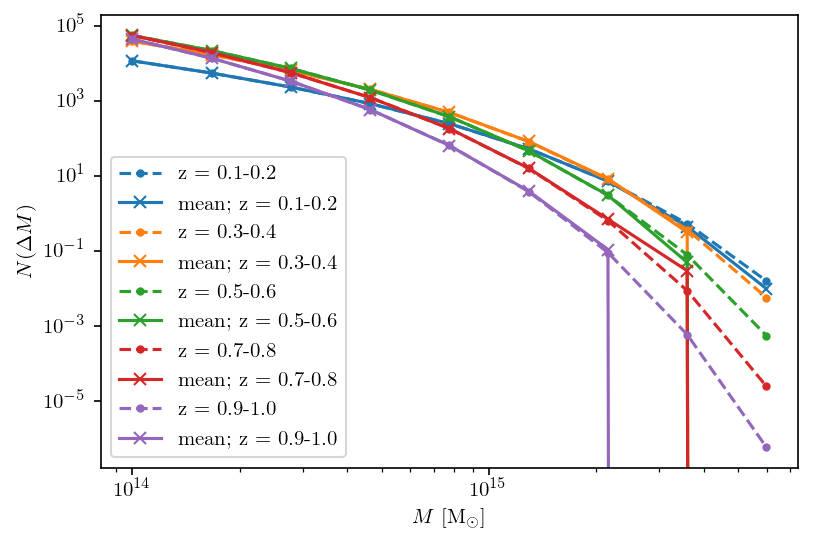

In [17]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j], #yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j], #yerr=N_counts_random_var_detailed[:, j],
                 c=color_map(j), marker = 'x', label = 'mean; z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

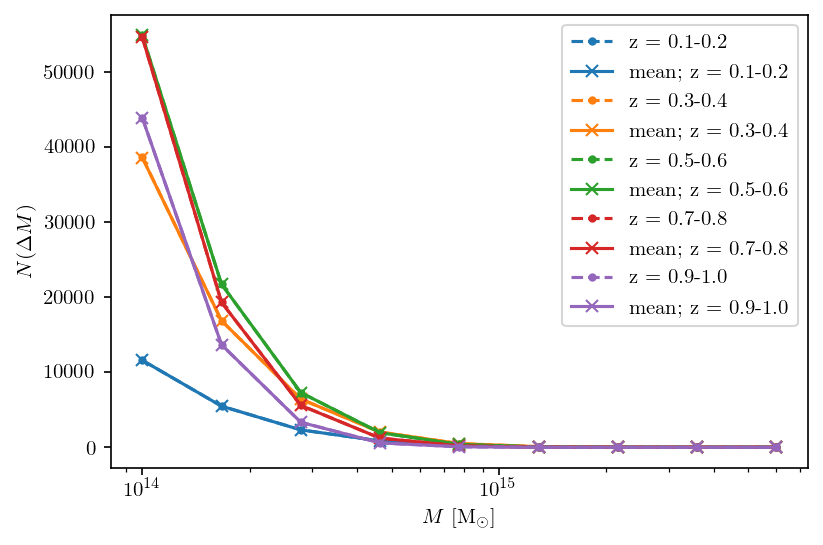

In [18]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('linear')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j], #yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j], #yerr=N_counts_random_var_detailed[:, j],
                 c=color_map(j), marker = 'x', label = 'mean; z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

## With error bars (log scale and linear scale)

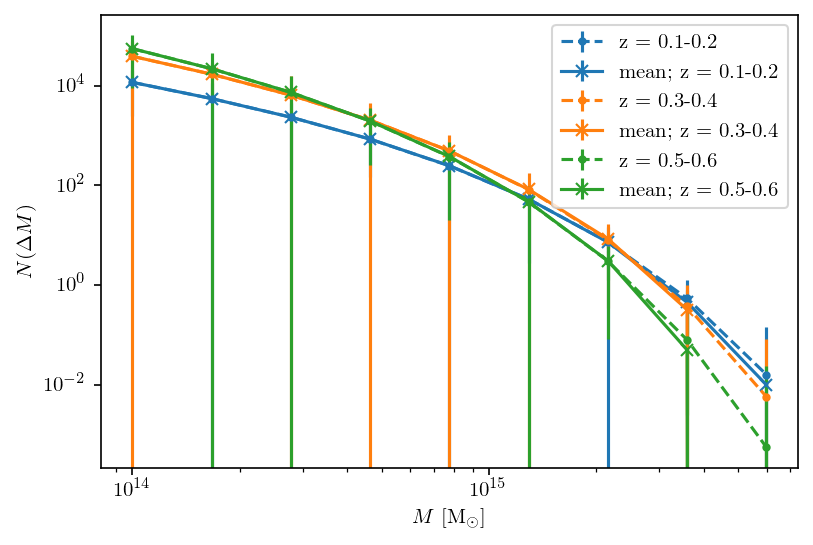

In [19]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(3): #len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j], yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j], yerr=N_counts_random_var_detailed[:, j],
                 c=color_map(j), marker = 'x', label = 'mean; z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'upper right')    
    

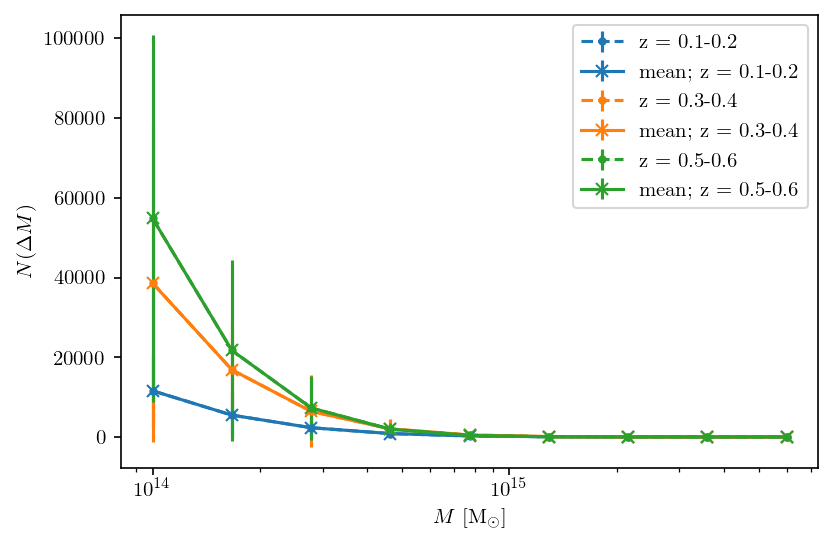

In [20]:
plt.figure()
plt.ylabel(r'$N(\Delta M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('linear')
#plt.xlim(1e15, 1e16)
#plt.ylim(0, 300)
for j in range(3): #len(z_min)):
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_detailed[:, j], yerr=np.sqrt(N_counts_detailed[:, j]),
                 c=color_map(j), linestyle = '--', marker = '.', label = 'z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
    plt.errorbar(10**log10masses_detailed[:-1], N_counts_random_mean_detailed[:, j], yerr=N_counts_random_var_detailed[:, j],
                 c=color_map(j), marker = 'x', label = 'mean; z = '+str(round(z_min[j], 2)) + '-' + str(round(z_max[j], 2)))
plt.legend(loc = 'best')    
    

# 

## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [ ]:
ccl.halos.hmfunc.MassFunc

In [ ]:
ccl.halos.hmfunc.MassFunc.get_mass_function

In [ ]:
ccl.massfunc

In [11]:
np.random.seed(2)

In [10]:
# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_g=0, Omega_k=0,
                       h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                       w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                       mass_function='tinker')

In [4]:
#Load the benchmarks
bench=np.loadtxt('/home/aizhana/CCL/benchmarks/data/model1_hmf.txt')
log10mass = bench[0:,0]
sigma = bench[0:,1]
log10invsigma = bench[0:,2]
log10massfunc = bench[0:,3]

In [5]:
bench

array([[ 1.000000e+01,  3.605507e+00, -5.569663e-01, -1.570650e+00],
       [ 1.050000e+01,  3.204972e+00, -5.058242e-01, -1.518198e+00],
       [ 1.100000e+01,  2.821836e+00, -4.505318e-01, -1.462083e+00],
       [ 1.150000e+01,  2.457596e+00, -3.905104e-01, -1.402880e+00],
       [ 1.200000e+01,  2.113854e+00, -3.250751e-01, -1.342187e+00],
       [ 1.250000e+01,  1.792304e+00, -2.534117e-01, -1.283641e+00],
       [ 1.300000e+01,  1.494680e+00, -1.745481e-01, -1.234955e+00],
       [ 1.350000e+01,  1.222696e+00, -8.731863e-02, -1.212136e+00],
       [ 1.400000e+01,  9.779681e-01,  9.675300e-03, -1.248659e+00],
       [ 1.450000e+01,  7.619025e-01,  1.181006e-01, -1.416499e+00],
       [ 1.500000e+01,  5.755757e-01,  2.398976e-01, -1.877337e+00],
       [ 1.550000e+01,  4.195639e-01,  3.772018e-01, -3.015292e+00],
       [ 1.600000e+01,  2.936924e-01,  5.321073e-01, -5.803086e+00]])

In [13]:
scale_fact = 1.

# setting up different cosmology configuration to match benchmarks and keep CLASS from crashing.
cosmo_ccl1_mf = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, Omega_g=0, Omega_k=0,
                       h=0.7, sigma8=0.8, n_s=0.96, Neff=0, m_nu=0.0,
                       w0=-1, wa=0, T_CMB=2.7, transfer_function='bbks',
                       mass_function='tinker')

In [14]:
cosmo_ccl1_mf

pyccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.7, n_s=0.96, sigma8=0.8, A_s=None, Omega_k=0, Omega_g=0, Neff=0, w0=-1, wa=0, T_CMB=2.7, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='bbks', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker', halo_concentration='duffy2008', emulator_neutrinos='strict')

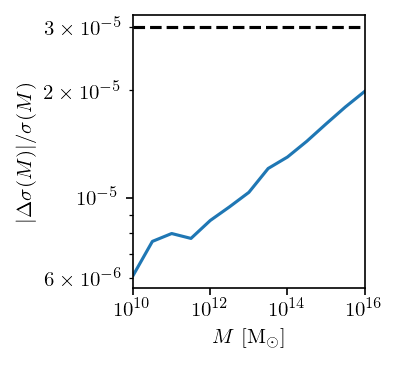

<Figure size 900x600 with 0 Axes>

In [6]:
accuracy = 3e-5

mass_function_fig_size = (paper_textwidth/3, fig_size[1])
mass_function_plot_adjust = plot_adjust.copy()
mass_function_plot_adjust["left"] = 0.3
mass_function_plot_adjust["right"] = 0.95

#This plot shows the relative difference in sigmaM predictions.
plt.figure(figsize=mass_function_fig_size)
plt.gcf().subplots_adjust(**mass_function_plot_adjust)
plt.ylabel(r'$|\Delta \sigma(M)|/\sigma(M)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.gca().set_xscale('log')
plt.plot(10**log10mass, np.abs(ccl.sigmaM(cosmo_ccl1_mf,10**log10mass,scale_fact)/sigma-1),
        c=color_map(0))
plt.axhline(accuracy, c="k", ls="--")
plt.yscale("log")
plt.locator_params(axis="x", numticks=4)
plt.xlim(left=1e10,right=1e16)
plt.savefig('hmf_model1.pdf')
plt.show()
plt.clf()

In [15]:
import matplotlib.pyplot as plt

In [22]:
log10mass1 = bench[5:-2,0]
log10mass1

array([12.5, 13. , 13.5, 14. , 14.5, 15. ])

/home/aizhana/.conda/envs/fast-mpi4py/lib/python3.7/site-packages/pyccl/pyutils.py:407: CCLWarning: The function massfunc is deprecated. Use MassFunc instead.
  warnings.warn(s, CCLWarning)


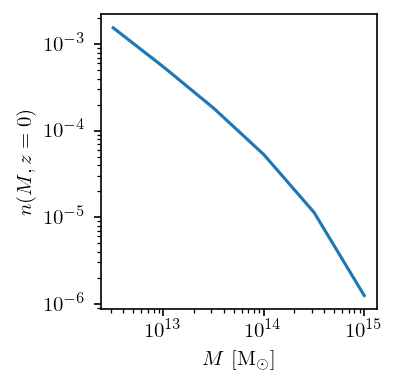

In [23]:
plt.figure(figsize=mass_function_fig_size)
plt.ylabel(r'$n(M, z=0)$')
plt.xlabel(r'$M$ [M$_{\odot}$]')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1e13, 1e15)
plt.plot(10**log10mass1, ccl.massfunc(cosmo_ccl1_mf,10**log10mass1,scale_fact), c=color_map(0))

In [9]:
ccl.tracers.NumberCountsTracer

pyccl.tracers.NumberCountsTracer

## Set up the prior on parameters

In [3]:
# param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'] 

lower = np.array([0, -1.5, -20, 0, 0, -0.5])
upper = np.array([0.6, 0, -18, 1, 6, 0.5])
prior = priors.Uniform(lower, upper)

## Set up the compressor
Must have the signature `compressor(data, args)` -> `np.array([n_summaries])`<br>
In this case we are going to do Gaussian score compression $$\mathbf{t} = \boldsymbol\theta_* + \mathbf{F}^{-1}\nabla_\theta^T\boldsymbol\mu_*\mathbf{C}^{-1}(\mathbf{d}-\boldsymbol\mu_*)$$ using the class `score.Gaussian`. For this we'll need some fiducial parameters, the mean its derivative at the fiducial parameters, the inverse covariance, and the inverse Fisher matrix

# Step 2 - Specifying simulation vector
## Set up the simulator
This must have the signature `simulator(parameters, seed, args, batch)` -> `np.array([batch, ndata])`

In [4]:
JLASimulator = jla.JLA_Model()

def simulator(theta, seed, simulator_args, batch):
    
    return JLASimulator.simulation(theta, seed)

simulator_args = None

/home/aizhana/pydelfi/examples/simulators/jla_supernovae/jla_parser.py:9: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype = None, names = True)


In [5]:
theta_fiducial = np.array([0.3, -0.75, -19.05, 0.125, 2.65, -0.05])

mu = JLASimulator.apparent_magnitude(theta_fiducial)
Cinv = JLASimulator.Cinv

h = np.array(abs(theta_fiducial))*0.01
dmudt = JLASimulator.dmudt(theta_fiducial, h)

Compressor = score.Gaussian(len(JLASimulator.data), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

# Step 1 - Specifying data vector. 
## Here the data vector is a compressed data vector

In [6]:
compressed_data = compressor(JLASimulator.data, compressor_args)

## Define ensemble of NDEs

In [7]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=6, n_data=6, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=6, n_data=6, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [8]:
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_m', 'w_0', 'M_\mathrm{B}', '\\alpha', '\\beta', '\\delta M'], 
                            results_dir = "simulators/jla_supernovae/results/",
                            input_normalization="fisher")

## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...
Done.
Removed no burn in


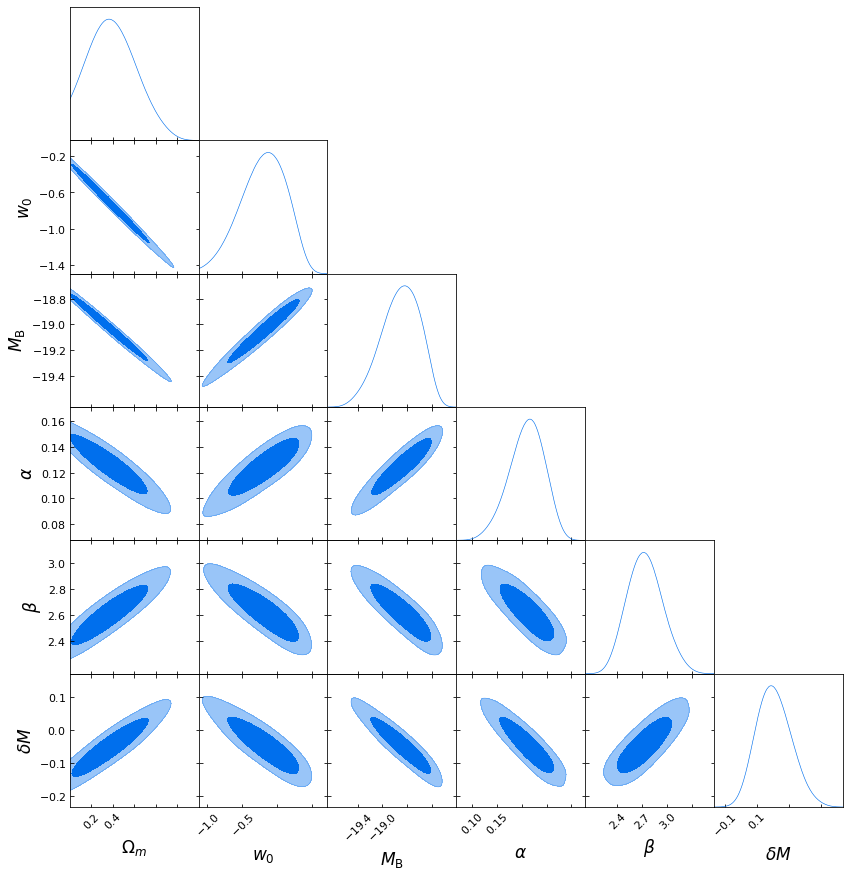

In [8]:
DelfiEnsemble.fisher_pretraining()

## Sequential Neural Likelihood

Population 1/20
Sampling proposal density...
Done.


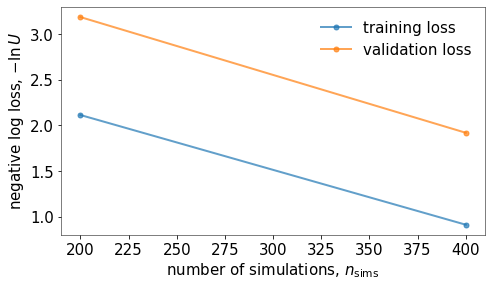

Population 2/20
Sampling proposal density...
Done.


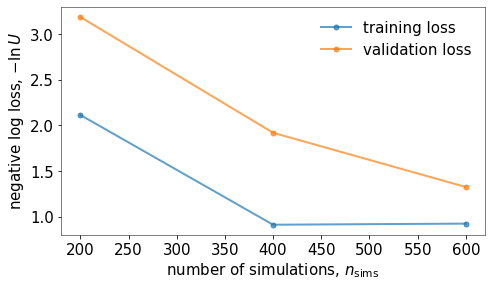

Population 3/20
Sampling proposal density...
Done.


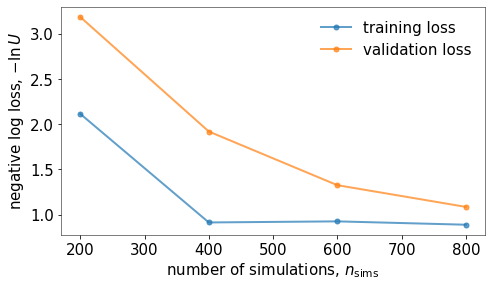

Population 4/20
Sampling proposal density...
Done.


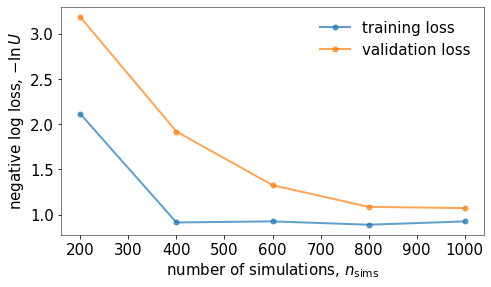

Population 5/20
Sampling proposal density...
Done.


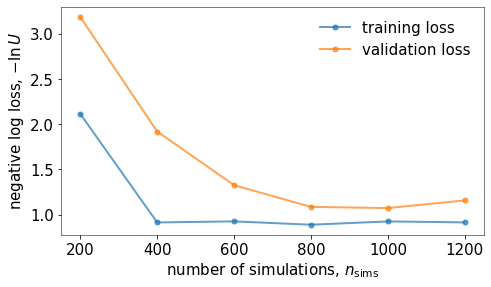

Population 6/20
Sampling proposal density...
Done.


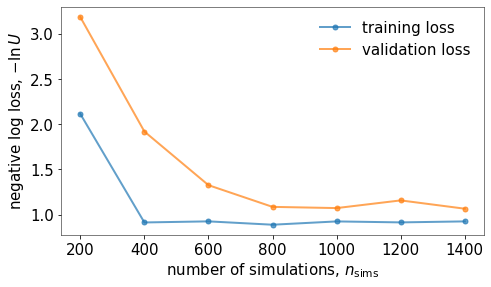

Population 7/20
Sampling proposal density...
Done.


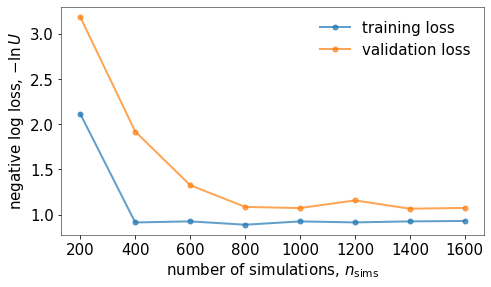

Population 8/20
Sampling proposal density...
Done.


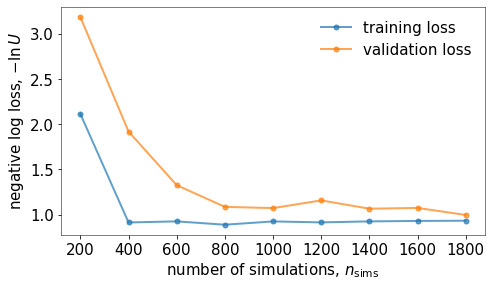

Population 9/20
Sampling proposal density...
Done.


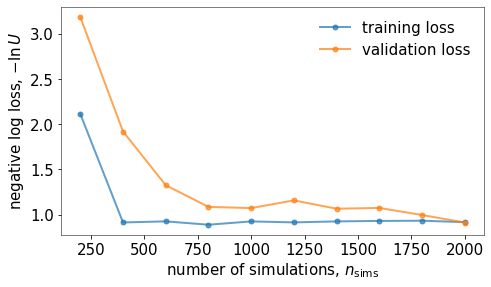

Population 10/20
Sampling proposal density...
Done.


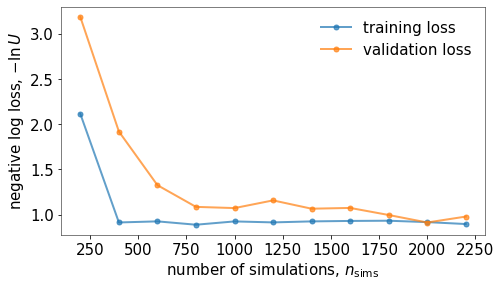

Population 11/20
Sampling proposal density...
Done.


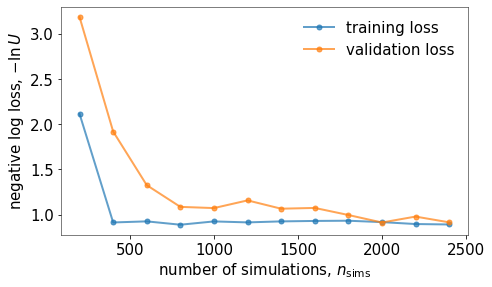

Population 12/20
Sampling proposal density...
Done.


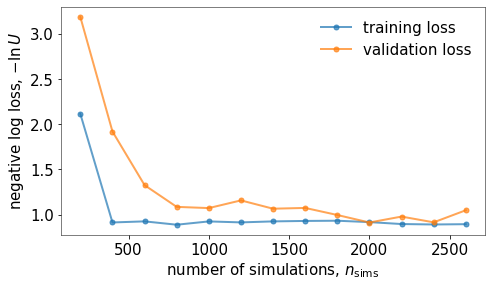

Population 13/20
Sampling proposal density...
Done.


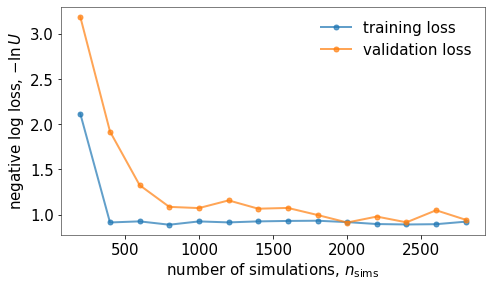

Population 14/20
Sampling proposal density...
Done.


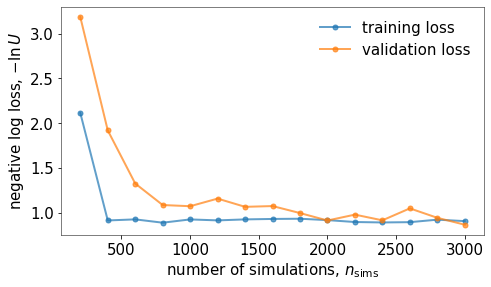

Population 15/20
Sampling proposal density...
Done.


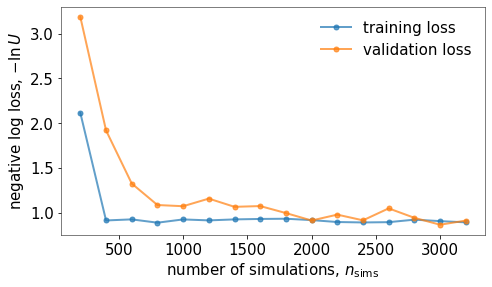

Population 16/20
Sampling proposal density...
Done.


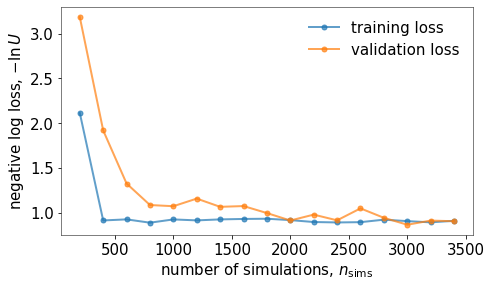

Population 17/20
Sampling proposal density...
Done.


In [ ]:
n_initial = 200
n_batch = 200
n_populations = 20

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20,
                       save_intermediate_posteriors=False)

## Sample the learned posterior

In [ ]:
x0 = DelfiEnsemble.posterior_samples[np.random.choice(np.arange(len(DelfiEnsemble.posterior_samples)), p=DelfiEnsemble.posterior_weights.astype(np.float32)/sum(DelfiEnsemble.posterior_weights), replace=False, size=DelfiEnsemble.nwalkers),:]
posterior_samples, posterior_weights, log_prob = DelfiEnsemble.emcee_sample(x0=x0)

## Alright let's plot it!
Feed it a list of `(n_samples, n_parameters)` arrays for making a triangle plot; in this case let's just plot the posterior samples.

In [ ]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples], weights=[posterior_weights])